In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import time

import gym
import numpy as np
import os
import ptan

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import collections

import seaborn as sns

sns.set_style('darkgrid')

## Solving the System of Equations

$\ddot{r} = - g$

### System of Equations

$y_0 = r$

$y_1 = \dot{r}$

---


$\dot{y}_0 = y_1$

$\dot{y}_1 =  -g$

In [2]:
class UniformGravity(gym.Env):
    metadata = {'render.modes': ['human']}
    
    # dt_s -- is the time step in seconds.
    def __init__(self, g = 9.8,  dt = 1.0, target_alt = 2.0, 
                 thrust_gs= 1.5, verbose = False, 
                 record_history = True, record_rate = 100):
        
        super(UniformGravity, self).__init__()
        self.record_rate = record_rate
        self.max_thrust = g*1.5
    
        # Actions
        self.action_space = gym.spaces.Box(low=np.array([-self.max_thrust]), 
                                           high=np.array([self.max_thrust]), 
                                           dtype=np.float32)
        
        # Obs (r,rdot,theta,theta_dot)
        self.observation_space = gym.spaces.Box(low=np.array([0,0]), 
                                                high=np.array([10**9,10**9]), 
                                                dtype=np.float32)
        
        self.record_history = record_history
        
        # setting the target altitude in natural units
        self.target_alt = target_alt
        
        self.dt = dt
        self.g = g
        
        self.max_time = 100.
        
    def reset(self):
        # Reset the state of the environment to an initial state
        self.steps = 0
        
        # Translational Coordinates
        self.r = 1.0
        self.r_dot = 0.0
        self.r_double_dot = 0.0

        self.elapsed_time = 0.0 # elapsed sim time in seconds
        
        # initialize the history array
        if self.record_history:
            self.trajectory = np.array([[self.r,self.r_dot]])
        
        obs = np.array([self.r,self.r_dot])
        
        return obs
    
    # continous actions = (mean thrust, mean counter clockwise rotation thrust)
    def step(self, action):
        
        # actions segragation
        thrust = np.clip(action[0], -self.max_thrust, self.max_thrust)

        # Execute one time step within the environment using RK4
        self.elapsed_time += self.dt

        # integrate
        y0_k1 = self.r_dot
        y1_k1 = -self.g + thrust
        
        y0_k2 = (self.r_dot + y1_k1*self.dt/2)
        y1_k2 = -self.g + thrust
         
        y0_k3 = (self.r_dot + y1_k2*self.dt/2)
        y1_k3 = -self.g + thrust
          
        y0_k4 = (self.r_dot + y1_k3*self.dt)
        y1_k4 = -self.g + thrust

        # Update 
        self.r = self.r + self.dt/6*(y0_k1 + 2*y0_k2 + 2*y0_k3 + y0_k4)
        self.r_dot = self.r_dot + self.dt/6*(y1_k1 + 2*y1_k2 + 2*y1_k3 + y0_k4)
        
        # prepare to output
        obs = np.array([self.r,self.r_dot])
        
        # If recording is enabled record the trajectory
        if (self.record_history) and (self.steps % self.record_rate == 0):
            self.trajectory = np.append(self.trajectory,[[self.r,self.r_dot]],axis=0)
        
        # reward 1 for every step not done, encouraging staying above ground
        # plus a penalty for every step not near the target altitude
        reward = (1.0 - 0.001*thrust/self.max_thrust + 0.01*np.abs(self.target_alt - self.r)/self.target_alt)
        
        # set if at the terminal state
        done = False
        
        # test for terminal state
        if ((self.r <= 1.0) | 
            (self.r > self.target_alt*3.0) | 
            (self.elapsed_time > self.max_time)):
            done = True
        
        return (obs, reward, done, {})
    
    def render(self, size=5, sample_traj_rate = 1):
        pass

## Example Policy

In [3]:
env = UniformGravity(dt = 0.1, verbose=True, target_alt = 1.75)

C:\Users\BVPHD\.conda\envs\py_torch\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [10]:
env.reset()

for t in range(20):
    if t < 8:
        a = [11.0]
    elif t < 8.5:
        a = [-1.0]
    else:
        a = [9.8]
        
    env.step(a)

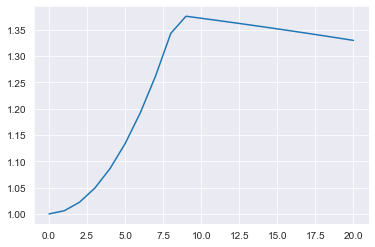

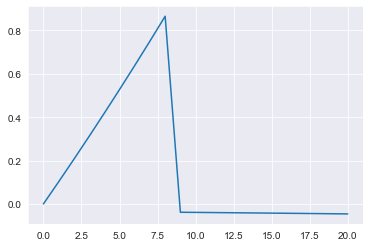

In [11]:
plt.plot(env.trajectory[:,0])
plt.show();

plt.plot(env.trajectory[:,1])
plt.show();

In [12]:
def test_net(net, env, count=10, device="cpu"):
    rewards = 0.0
    steps = 0
    # play count episodes
    for _ in range(count):
        obs = env.reset()
        while True:
            obs_v = ptan.agent.float32_preprocessor([obs])
            obs_v = obs_v.to(device)
            mu_v = net(obs_v)[0]
            action = mu_v.squeeze(dim=0).data.cpu().numpy()
            state, reward, done, _ = env.step(action)
            rewards += reward
            steps += 1
            if done:
                break
    return rewards / count, steps / count

In [77]:
def calc_logprob(mu_v, var_v, actions_v):
    p1 = - ((mu_v - actions_v) ** 2) / (2*var_v.clamp(min=1e-3))
    p2 = - torch.log(torch.sqrt(2 * np.pi * var_v))
    return p1 + p2

In [79]:
HID_SIZE = 16

class ModelA2C(nn.Module):
    def __init__(self, obs_size, act_size):
        super(ModelA2C, self).__init__()

        self.mu = nn.Sequential(
            nn.Linear(obs_size, HID_SIZE),
            nn.ReLU(),
            nn.Linear(HID_SIZE, act_size)
        )

        self.var = self.mu = nn.Sequential(
            nn.Linear(obs_size, HID_SIZE),
            nn.ReLU(),
            nn.Linear(HID_SIZE, act_size)
        )

        self.value = self.mu = nn.Sequential(
            nn.Linear(obs_size, HID_SIZE),
            nn.ReLU(),
            nn.Linear(HID_SIZE, 1)
        )

    def forward(self, x):
        return self.mu(x), torch.abs(self.var(x)), self.value(x)

In [80]:
class AgentA2C(ptan.agent.BaseAgent):
    def __init__(self, net, device="cpu"):
        self.net = net
        self.device = device

    def __call__(self, states, agent_states):
        states_v = ptan.agent.float32_preprocessor(states)
        states_v = states_v.to(self.device)

        mu_v, var_v, _ = self.net(states_v)
        mu = mu_v.data.cpu().numpy()
        sigma = torch.sqrt(var_v).data.cpu().numpy()
        actions = np.random.normal(mu, sigma)
        return actions, agent_states

In [81]:
def unpack_batch_a2c(batch, net, last_val_gamma, device="cpu"):
    """
    Convert batch into training tensors
    :param batch:
    :param net:
    :return: states variable, actions tensor, reference values variable
    """
    states = []
    actions = []
    rewards = []
    not_done_idx = []
    last_states = []
    
    for idx, exp in enumerate(batch):
        states.append(exp.state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        if exp.last_state is not None:
            not_done_idx.append(idx)
            last_states.append(exp.last_state)
    
    states_v = ptan.agent.float32_preprocessor(states).to(device)
    actions_v = torch.FloatTensor(actions).to(device)

    # handle rewards
    rewards_np = np.array(rewards, dtype=np.float32)
    if not_done_idx:
        last_states_v = ptan.agent.float32_preprocessor(last_states).to(device)
        last_vals_v = net(last_states_v)[2]
        last_vals_np = last_vals_v.data.cpu().numpy()[:, 0]
        rewards_np[not_done_idx] += last_val_gamma * last_vals_np

    ref_vals_v = torch.FloatTensor(rewards_np).to(device)
    return states_v, actions_v, ref_vals_v

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = UniformGravity(dt = 1.0, verbose=True, target_alt = 1.75, record_history = False)
test_env = UniformGravity(dt = 1.0, verbose=True, target_alt = 1.75, record_rate = 1)

net = ModelA2C(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
print(net)

agent = AgentA2C(net, device=device)

ModelA2C(
  (mu): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
  (var): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
  (value): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)


C:\Users\BVPHD\.conda\envs\py_torch\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### Test Net Is Neutral (near zero means, near zero variances)

In [83]:
s = env.reset()
s_v = torch.FloatTensor([s]).to(device)
net(s_v)

(tensor([[0.2802]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[0.2363]], device='cuda:0', grad_fn=<AbsBackward>),
 tensor([[0.2802]], device='cuda:0', grad_fn=<AddmmBackward>))

In [84]:
agent(s,None) # s needs to be numpy array

(array([0.48252525]), None)

### Pretrain so that we have good initial settings (the mentor)

In [115]:
net = ModelA2C(env.observation_space.shape[0], env.action_space.shape[0]).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.01)

go_thrust_v = torch.FloatTensor([[10.0]]).to(device)

# this pumps the variance parameters so we start off with high exploration
for _ in range(100):
    optimizer.zero_grad()
    
    mu_v, var_v, value_v = net(s_v)
    ent_v = -(torch.log(2*np.pi*var_v) + 1)/2
    entropy_loss_v =  0.00001*ent_v.mean()
    mu_loss_v = ((mu_v - go_thrust_v)**2).mean()
    
    loss_v = mu_loss_v + entropy_loss_v
    
    loss_v.backward()
    optimizer.step()
    
agent = AgentA2C(net, device=device)

In [116]:
net(s_v) # mean near (max_thrust,0) large variances for exploration

(tensor([[9.3695]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[4.0479]], device='cuda:0', grad_fn=<AbsBackward>),
 tensor([[9.3695]], device='cuda:0', grad_fn=<AddmmBackward>))

In [117]:
agent(s,None)

(array([9.77622398]), None)

In [126]:
GAMMA = 0.999
REWARD_STEPS = 2
BATCH_SIZE = 32
LEARNING_RATE = 0.01
ENTROPY_BETA = 0.0

TEST_ITERS = 5000

exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, GAMMA, 
                                                       steps_count=REWARD_STEPS)

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

batch = []
best_reward = None

#reward_100 = collections.deque(maxlen=100)
    
for step_idx, exp in enumerate(exp_source):
    '''
    rewards_steps = exp_source.pop_rewards_steps()
    if rewards_steps:
        rewards, steps = zip(*rewards_steps)
        #reward_100.append(rewards[0])
    '''

    if step_idx % TEST_ITERS == 0:
        ts = time.time()
        rewards, steps = test_net(net, test_env, device=device)
        print("Test done is %.2f sec, reward %.3f, steps %d" %\
              (time.time() - ts, rewards, steps))
        #writer.add_scalar("test_reward", rewards, step_idx)
        #writer.add_scalar("test_steps", steps, step_idx)
        if (best_reward is None) or (best_reward < rewards):
            if best_reward is not None:
                print("Best reward updated: %.8f -> %.8f" % (best_reward, rewards))
            best_reward = rewards

    batch.append(exp)
    if len(batch) < BATCH_SIZE:
        continue

    states_v, actions_v, vals_ref_v = unpack_batch_a2c(batch, net, device=device,
                                                       last_val_gamma=GAMMA**REWARD_STEPS)
    batch.clear()

    optimizer.zero_grad()
    
    mu_v, var_v, value_v = net(states_v)
    loss_value_v = F.mse_loss(value_v.squeeze(-1), vals_ref_v)

    adv_v = vals_ref_v.unsqueeze(dim=-1) - value_v.detach()
    log_prob_v = adv_v * calc_logprob(mu_v, var_v, actions_v)
    loss_policy_v = -log_prob_v.mean()
    ent_v = -(torch.log(2*np.pi*var_v) + 1)/2
    entropy_loss_v = ENTROPY_BETA * ent_v.mean()

    loss_v = loss_policy_v + entropy_loss_v + loss_value_v
    loss_v.backward()
    optimizer.step()

Test done is 0.01 sec, reward 1.029, steps 1
Test done is 0.01 sec, reward 1.029, steps 1
Test done is 0.01 sec, reward 1.029, steps 1
Best reward updated: 1.02928558 -> 1.02929496
Test done is 0.01 sec, reward 1.029, steps 1
Test done is 0.01 sec, reward 1.029, steps 1
Test done is 0.01 sec, reward 1.029, steps 1
Test done is 0.01 sec, reward 1.029, steps 1
Test done is 0.01 sec, reward 1.029, steps 1
Best reward updated: 1.02929496 -> 1.02929613
Test done is 0.01 sec, reward 1.029, steps 1
Test done is 0.01 sec, reward 1.029, steps 1
Test done is 0.01 sec, reward 1.029, steps 1
Test done is 0.01 sec, reward 1.029, steps 1
Test done is 0.01 sec, reward 1.029, steps 1
Best reward updated: 1.02929613 -> 1.02933389
Test done is 0.01 sec, reward 1.029, steps 1
Test done is 0.01 sec, reward 1.029, steps 1
Test done is 0.01 sec, reward 1.029, steps 1
Test done is 0.01 sec, reward 1.029, steps 1
Test done is 0.01 sec, reward 1.029, steps 1
Test done is 0.01 sec, reward 1.028, steps 1
Test do

KeyboardInterrupt: 

In [127]:
states_v

tensor([[ 1.0000,  0.0000],
        [ 1.0000,  0.0000],
        [ 1.0000,  0.0000],
        [ 3.4500,  4.9000],
        [ 3.4609, -4.0615],
        [ 1.8494,  0.1616],
        [ 1.0000,  0.0000],
        [ 1.0000,  0.0000],
        [ 1.0000,  0.0000],
        [ 3.4500,  4.9000],
        [ 4.6877, -1.6079],
        [ 1.0000,  0.0000],
        [ 1.0000,  0.0000],
        [ 1.0000,  0.0000],
        [ 2.4468,  2.8936],
        [ 1.0000,  0.0000],
        [ 1.0000,  0.0000],
        [ 3.4500,  4.9000],
        [ 4.8614, -1.2606],
        [ 3.3184, -2.0354],
        [ 1.0000,  0.0000],
        [ 1.0000,  0.0000],
        [ 1.0000,  0.0000],
        [ 1.0000,  0.0000],
        [ 3.4500,  4.9000],
        [ 1.0000,  0.0000],
        [ 3.4500,  4.9000],
        [ 4.4045, -2.1744],
        [ 1.0000,  0.0000],
        [ 3.4500,  4.9000],
        [ 2.9802, -5.0230],
        [ 1.0000,  0.0000]], device='cuda:0')

In [128]:
actions_v

tensor([[-2.1120e+01],
        [-1.4923e+01],
        [ 1.6742e+01],
        [ 2.1845e-02],
        [ 4.2477e+01],
        [-9.0593e+00],
        [ 7.0059e+00],
        [ 8.8742e+00],
        [ 1.7579e+01],
        [ 2.4755e+00],
        [ 3.9308e+01],
        [-2.1447e+01],
        [-4.3363e+00],
        [ 1.2694e+01],
        [ 7.2891e-01],
        [-8.4034e+00],
        [ 1.4867e+01],
        [ 2.8227e+00],
        [ 9.2354e+00],
        [-2.2354e+00],
        [ 1.6484e+00],
        [-5.8090e-01],
        [ 3.1807e+00],
        [ 1.4880e+01],
        [ 7.7962e+00],
        [ 2.1539e+01],
        [ 1.9090e+00],
        [ 2.0480e+00],
        [ 1.5098e+01],
        [-9.3967e-01],
        [ 8.4703e+00],
        [-6.3376e+00]], device='cuda:0')

In [129]:
vals_ref_v

tensor([1.0753, 1.0753, 3.3697, 3.5127, 2.0515, 1.0530, 1.0118, 1.0063, 3.4279,
        2.0362, 1.0206, 1.0753, 1.0450, 2.0075, 1.0054, 1.0569, 3.4361, 3.4393,
        2.0445, 1.0372, 1.0275, 1.0340, 1.0230, 2.0391, 1.0315, 3.4144, 2.0333,
        1.0193, 3.2639, 2.0310, 1.0249, 1.0508], device='cuda:0')

In [130]:
s = env.reset()
s_v = torch.FloatTensor([s]).to(device)
net(s_v)

(tensor([[1.5413]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[170.5512]], device='cuda:0', grad_fn=<AbsBackward>),
 tensor([[1.5413]], device='cuda:0', grad_fn=<AddmmBackward>))

In [112]:
test_net(net, test_env, count=1, device=device)
#test_net(up_net, test_env, count=1)

(1.0288869580103426, 1.0)

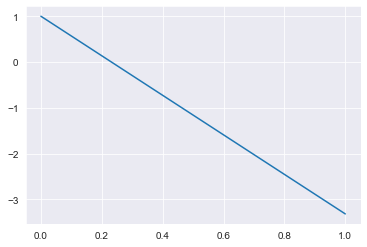

In [114]:
plt.plot(test_env.trajectory[:,0])
plt.show()



## Vanilla Policy Gradient Method

In [177]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('using device: ',device)

HIDDEN_SIZE = 128

class PGN(nn.Module):
    def __init__(self, in_size):
        super(PGN,self).__init__()
        
        self.actions_mu = nn.Sequential(
            nn.Linear(in_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, 2)
        )
    
        self.actions_var = nn.Sequential(
            nn.Linear(in_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, 2)
        )
        
        self.values =  nn.Sequential(
            nn.Linear(in_size, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, 1)
        )
    
    def __call__(self, x):
        return self.actions_mu(x), self.actions_var(x), self.values(x)
    
policy_net = PGN(4).to(device)

policy_net

using device:  cpu


PGN(
  (actions_mu): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
  (actions_var): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
  (values): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [149]:
ridx = np.random.choice(range(len(traj_s)),size = 1000)
states_v = torch.FloatTensor(np.array(traj_s)[ridx])
actions_v = torch.LongTensor(np.array(traj_a)[ridx])
#actions_v = torch.eye(4)[traj_a]

In [178]:
optimizer = optim.Adam(policy_net.parameters(), lr=0.001)

In [152]:
for e in range(5000):
    optimizer.zero_grad()
    mu_v, var_v, _ = policy_net(states_v)
    
    loss_v = ((mu_v - actions_v)**2).mean()
    loss_v.backward()
    optimizer.step()
    
    if e % 100 == 0:
        print(loss_v.item())

0.611042857170105
0.07870986312627792
0.04247419536113739
0.029623961076140404
0.0246701892465353
0.022615090012550354
0.021483683958649635
0.020682865753769875
0.01997537910938263
0.019331539049744606
0.01875515654683113
0.018252111971378326
0.017818685621023178
0.01744617521762848
0.01712161675095558
0.016824597492814064
0.01656264252960682
0.01633056439459324
0.016125833615660667
0.015943657606840134
0.015776731073856354
0.015621383674442768
0.015472836792469025
0.015327652916312218
0.01518517266958952
0.015045098960399628
0.01490660198032856
0.01477011013776064
0.014637439511716366
0.014506872743368149
0.014379916712641716
0.014262971468269825
0.014149095863103867
0.014043898321688175
0.013938740827143192
0.01384030096232891
0.013742691837251186
0.013647002167999744
0.013478003442287445
0.013384887017309666
0.013283448293805122
0.013193108141422272
0.013111486099660397
0.01303156465291977
0.012958995997905731
0.012887602671980858
0.012806102633476257
0.012738815508782864
0.01267056

In [162]:
state = env.reset()
episode_R = 0.0

while True:
    state_v = torch.FloatTensor([state])
    mu_v, var_v, _ = policy_net(state_v)
    mu = mu_v.data.cpu().numpy()[0]
    
    state, reward, is_done, _ = env.step(mu)
    episode_R += reward
    if is_done:
        break

In [163]:
episode_R

-631.6050344747143

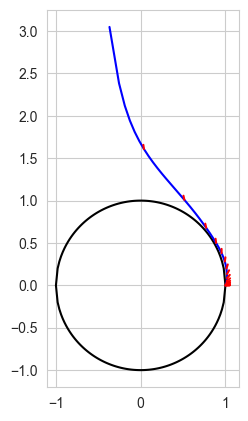

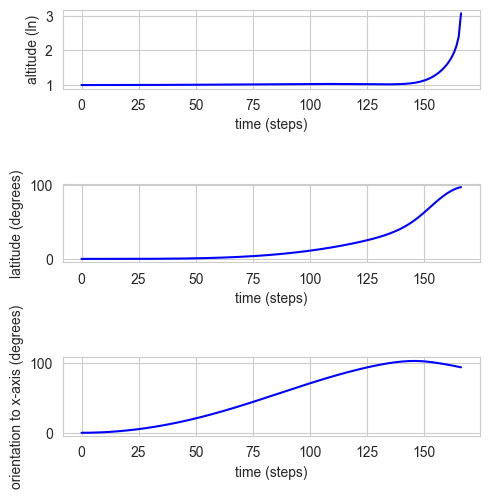

In [164]:
sns.set_style('whitegrid')
env.render()

In [171]:
def calc_logprob(mu_v, var_v, actions_v):
    p1 = - ((mu_v - actions_v) ** 2) / (2*var_v.clamp(min=1e-3))
    p2 = - torch.log(torch.sqrt(2 * np.pi * var_v))
    return p1 + p2

tensor([[-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209],
        [-0.2690,  0.1209]], grad_fn=<AddBackward0>)


RuntimeError: The size of tensor a (10) must match the size of tensor b (2) at non-singleton dimension 1

-1572.8280186113989 4055.6625553967274


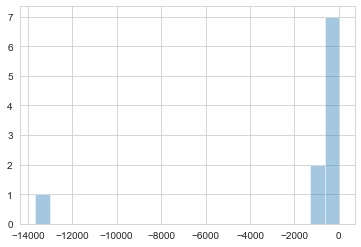

In [174]:
print(np.mean(total_rewards), np.std(total_rewards))
sns.distplot(total_rewards,kde=False);

Episode Reward:  -1105.2090478697733


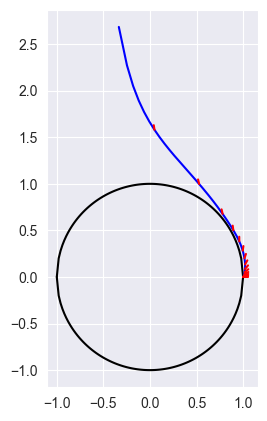

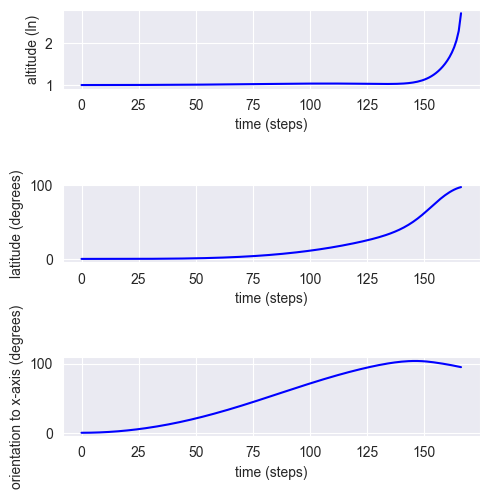

In [176]:
s = env.reset()

episode_reward = 0.0

program_cmd_history = []

done = False
while not done:
    s_v = torch.FloatTensor(s).unsqueeze(0).to(device)
    mu_v, var_v, _ = policy_net(s_v)
    mu = mu_v.data.cpu().numpy()
    var = var_v.data.cpu().numpy()
    a = [np.random.normal(loc=mu[0,0],scale=np.abs(var[0,0])),
         np.random.normal(loc=mu[0,1],scale=np.abs(var[0,1]))]

    program_cmd_history.append(a)    
    s, r, done,_ = env.step(a)
    episode_reward +=r

print('Episode Reward: ', episode_reward)
sns.set_style('darkgrid')
env.render()

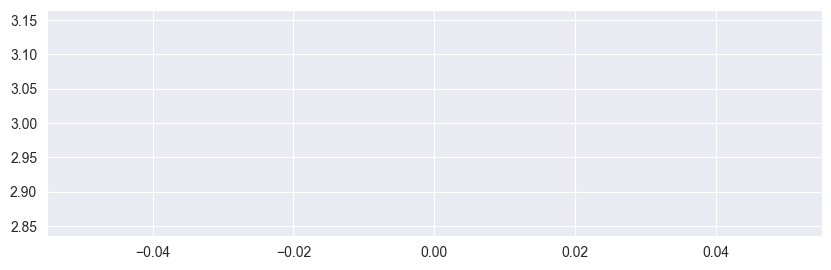

In [95]:
plt.figure(figsize=(10,3), dpi=100)
plt.plot(program_cmd_history);